**Лекция 10**

# Гребневая регрессия и метод LASSO

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Оптимизация-с-помощью-scipy.optimize" data-toc-modified-id="Оптимизация-с-помощью-scipy.optimize-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Оптимизация с помощью <code>scipy.optimize</code></a></span><ul class="toc-item"><li><span><a href="#Оптимизация-с-ограничением" data-toc-modified-id="Оптимизация-с-ограничением-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Оптимизация с ограничением</a></span></li><li><span><a href="#Метод-штрафных-функций" data-toc-modified-id="Метод-штрафных-функций-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Метод штрафных функций</a></span></li></ul></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Линейная регрессия</a></span><ul class="toc-item"><li><span><a href="#Генерация-данных" data-toc-modified-id="Генерация-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Генерация данных</a></span></li><li><span><a href="#Поиск-коэффициентов-регрессии" data-toc-modified-id="Поиск-коэффициентов-регрессии-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Поиск коэффициентов регрессии</a></span></li></ul></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Гребневая регрессия</a></span><ul class="toc-item"><li><span><a href="#Выбор-константы-регуляризации" data-toc-modified-id="Выбор-константы-регуляризации-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выбор константы регуляризации</a></span></li></ul></li><li><span><a href="#Лассо-Тибширани" data-toc-modified-id="Лассо-Тибширани-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Лассо Тибширани</a></span></li><li><span><a href="#Сравнение-лассо-и-гребневой-регрессии" data-toc-modified-id="Сравнение-лассо-и-гребневой-регрессии-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Сравнение лассо и гребневой регрессии</a></span></li><li><span><a href="#Источники" data-toc-modified-id="Источники-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [1]:
# Imports
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import graph_support

In [2]:
# Styles
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 6
cm = plt.cm.tab10  # Colormap
scale = 2

import seaborn
seaborn.set_style('whitegrid')

In [3]:
%%html
<style>
    .container.slides .celltoolbar, .container.slides .hide-in-slideshow {display: None ! important;}
</style>

---

## Оптимизация с помощью `scipy.optimize` ##

На этом занятии нам потребуется решать оптимизационные задачи.
Мы будем делать это с помощью пакета `scipy.optimize`, предоставляющего несколько часто используемых алгоритмов оптимизации, поэтому вначале немного познакомимся с ним.

- **Алгоритм безусловной оптимизации Бройдена &mdash; Флетчера &mdash; Гольдфарба &mdash; Шанно ([BFGS](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE))** &mdash;
использование градиента целевой функции
- **Последовательное квадратичное программирования ([SLSQP](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5))** &mdash;
последовательное решение задач квадратичного программирования, аппроксимирующих данную задачу оптимизации
- **Симплекс-метод [Нелдера &mdash; Мида](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9D%D0%B5%D0%BB%D0%B4%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%9C%D0%B8%D0%B4%D0%B0)** &mdash;
последовательное перемещение и деформирование симплекса вокруг точки экстремума
- **Алгоритм COBYLA ([Constrained Optimization By Linear Approximation](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms))** &mdash;
ограниченная оптимизация с помощью линейной аппроксимации

В качестве тренировки мы будем решать следующую задачу: \
Какая точка на линии $ax + by + c = 0$ находится ближе всего к началу координат? \
Или, если пользоваться формальной записью:
$$
\left\{
\begin{aligned}
    & \min \| \mathbf{x} \| \\
    & x_1 + 2x_2 - 4 = 0
\end{aligned}
\right..
$$

Таким образом, мы имеем дело с **условной однокритериальной двухпараметрической** оптимизационной задачей. \
Её решение будет зависеть от значения слова &laquo;ближе&raquo;, т.е. от выбора нормы. \
Воспользуемся октаэдрической ($L_1$) и евклидовой ($L_2$) нормами, чтобы увидеть, какая между ними разница.

### Оптимизация с ограничением

In [4]:
import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

In [5]:
# functions for norm plots
def x_t(t, r, p):
    return r * np.sign(np.cos(t)) * np.abs(np.cos(t))**(2/p)

def y_t(t, r, p):
    return r * np.sign(np.sin(t)) * np.abs(np.sin(t))**(2/p)

In [6]:
# optimization with L1 norm and constraint
def Q_obj_1(X):
    '''Q - objective function'''
    return np.linalg.norm(X, ord=1)

def constr(X):
    '''Constraint (x + 2y = 4)'''
    return X[0] + 2*X[1] - 4

In [7]:
# make optimization
x_0 = (4, 0)
nonlinear_constraint = NonlinearConstraint(constr, 0., 0.)
X1 = minimize(Q_obj_1, x_0, method='SLSQP', constraints=nonlinear_constraint, options={'disp': True}).x
print(X1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.000001282913686
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
[-8.55275791e-07  2.00000043e+00]


$$
\left\{
\begin{aligned}
    & \min \| \mathbf{x} \| \\
    & x_1 + 2x_2 - 4 = 0
\end{aligned}
\right.
$$

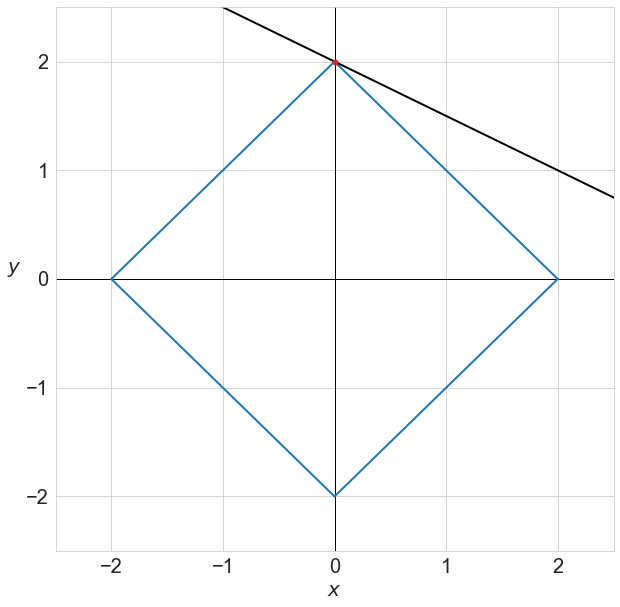

In [8]:
graph_support.hide_code_in_slideshow()

# plot results
t = np.linspace(0, 2*np.pi, 101)
r = LA.norm(X1)

seaborn.set_style("whitegrid")
plt.figure(figsize=(10, 10))
plt.axhline(y=0, c='k', lw=1)
plt.axvline(x=0, c='k', lw=1)
plt.plot(x_t(t, r, 1), y_t(t, r, 1))
plt.plot([-2, 4], [3, 0], 'k')
plt.plot(*X1, 'o', ms=5, c=cm(3))

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$", rotation='horizontal', horizontalalignment='right');

### Метод штрафных функций ###

In [9]:
# optimization with L2 norm and penalty 

def Q_obj_2(X):
    '''Q - objective function'''
    penalty = LA.norm(X[0] + 2*X[1] - 4)
    return np.linalg.norm(X, ord=2) + penalty

In [10]:
# make optimization
x_0 = (0, 0)
X2 = minimize(Q_obj_2, x_0, method='nelder-mead', options={'xtol': 1e-6, 'disp': True}).x
print(X2)

Optimization terminated successfully.
         Current function value: 1.788854
         Iterations: 151
         Function evaluations: 286
[0.79999977 1.60000012]


$$
\left\{
\begin{aligned}
    & \min \| \mathbf{x} \| \\
    & x_1 + 2x_2 - 4 = 0
\end{aligned}
\right.
$$

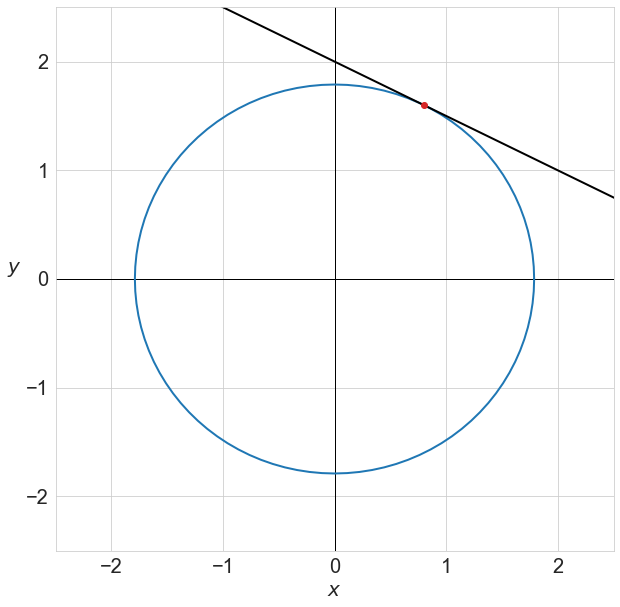

In [11]:
graph_support.hide_code_in_slideshow()

# plot results
t = np.linspace(0, 2*np.pi, 101)
r = LA.norm(X2)

seaborn.set_style("whitegrid")
plt.figure(figsize=(10, 10))
plt.axhline(y=0, c='k', lw=1)
plt.axvline(x=0, c='k', lw=1)
plt.plot(x_t(t, r, 2), y_t(t, r, 2))
plt.plot([-2, 4], [3, 0], 'k')
plt.plot(*X2, 'o', c=cm(3))

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$", rotation='horizontal', horizontalalignment='right');

Итак, мы решили две оптимизационные задачи.

1. Формулировка **с ограничением**, расстояние определяется по **норме $L_1$**, используется **алгоритм SLSQP**.
2. Формулировка **со штрафной функцией**, расстояние определяется по **норме $L_2$**, используется **алгоритм Нелдера &mdash; Мида**.

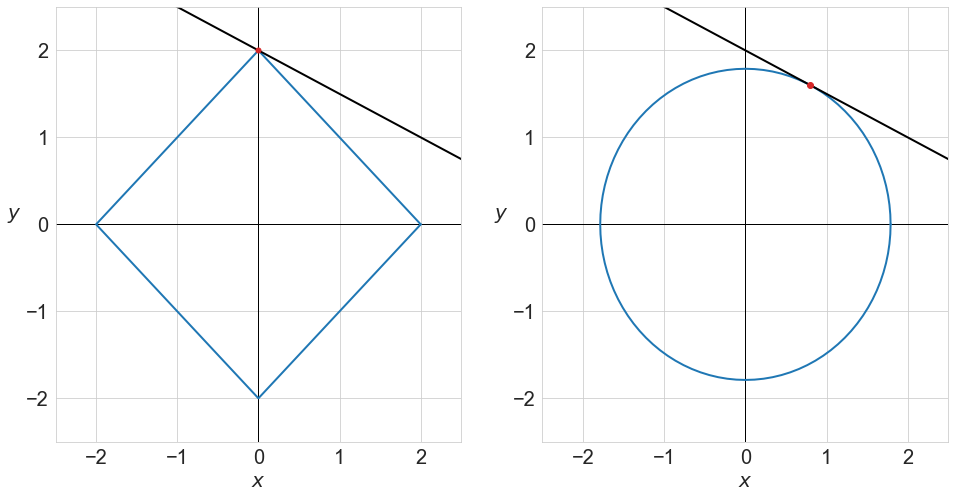

In [12]:
graph_support.hide_code_in_slideshow()

# plot results
t = np.linspace(0, 2*np.pi, 101)
r1 = LA.norm(X1)
r2 = LA.norm(X2)


seaborn.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axhline(y=0, c='k', lw=1)
ax1.axvline(x=0, c='k', lw=1)
ax1.plot(x_t(t, r1, 1), y_t(t, r1, 1))
ax1.plot([-2, 4], [3, 0], 'k')
ax1.plot(*X1, 'o', ms=5, c=cm(3))
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$y$", rotation='horizontal', horizontalalignment='right');

ax2.axhline(y=0, c='k', lw=1)
ax2.axvline(x=0, c='k', lw=1)
ax2.plot(x_t(t, r2, 2), y_t(t, r2, 2))
ax2.plot([-2, 4], [3, 0], 'k')
ax2.plot(*X2, 'o', c=cm(3))

ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$", rotation='horizontal', horizontalalignment='right');

Оптимизация с использованием **нормы $L_1$**: оптимальное решение является **разреженным**.
Разреженное решение позволяет производить **отбор признаков**.

Решение с использованием **нормы $L_2$** отбор признаков не производит.
Напротив, оно часто имеет много близких к нулю компонент, мало влияющих на целевую функцию.

---

## Линейная регрессия ##

В качестве примера мы снова рассмотрим полиномиальную регрессию.

### Генерация данных ###

In [13]:
def pol(a, x):
    return np.sum([a[i]*x**i for i in range(len(a))], axis=0)

In [14]:
# Define the data
np.random.seed(123)
Ns = 10 # Number of samples
x_lim = np.array([-1, 1])

# Underlying functional relation
fun = pol
a = [2, 3]
label = f'{a[0]} + {a[1]}x'

# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(Ns)  # Noise

# Features and output
x = np.random.uniform(x_lim[0], x_lim[1], Ns)  # Independent variable x
y = fun(a, x) + err  # Dependent variable

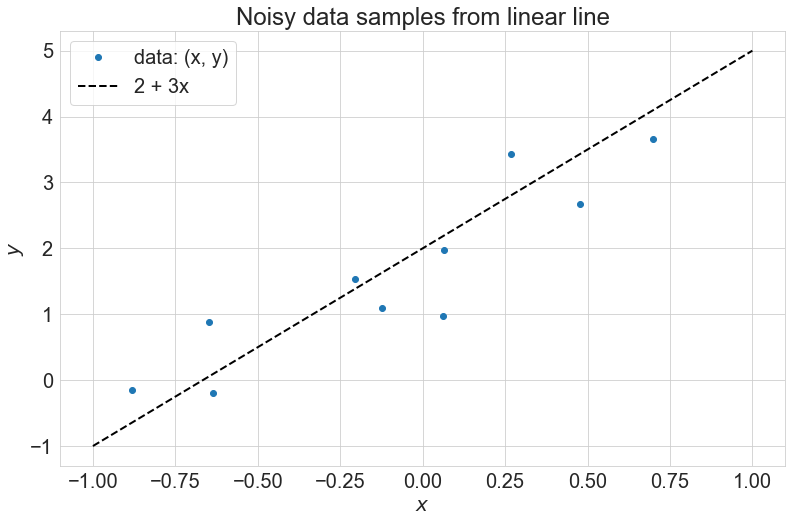

In [15]:
graph_support.hide_code_in_slideshow()

# Show data
X = np.linspace(x_lim[0], x_lim[1], 100)
plt.figure(figsize=(13, 8))
plt.title('Noisy data samples from linear line')
plt.plot(x, y, 'o', label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### Поиск коэффициентов регрессии

Вспомним постановку и решение задачи восстановления регрессии.

Будем работать с линейной моделью регрессии, являющейся по определению линейной комбинацией признаков с коэффициентами $\alpha \in \mathbb{R}^n$:
$$ g(x, \alpha) = \sum_{j=1}^n \alpha_j f_j(x). $$

В нашем случае признаками являются базисные полиномы $p(x) = \{1, x, \ldots, x^{n-1}\}$:
$$ g(x, \alpha) = \sum_{j=1}^{n} \alpha_j p_j(x).$$

Матрица объекты&ndash;признаки в этом случае выглядит так:
$$
  \mathbf{F} = 
  \begin{pmatrix}
    1      & x_1    & \ldots & x_1^{n-1} \\
    \vdots & \vdots & \ddots & \vdots    \\
    1      & x_m    & \ldots & x_m^{n-1} \\
  \end{pmatrix}.
$$

Функционал качества $Q$ выглядит, как обычно:
$$ Q(\alpha) = \left\Vert F\alpha - y \right\Vert^2. $$

Искомые коэффициенты при базисных полиномах $\alpha^*$ можно найти с помощью псевдообратной матрицы $F^{+}$:
$$ \alpha^* = (F^{\top} F)^{-1} F^{\top} y = F^{+} y. \label{eq:alpha-res}\tag{1}$$

In [16]:
# The number of fetures
Nf = 7
# Stack X with ones to be fitted by OLS
F = np.ones_like(x)
for i in range(1, Nf):
    F = np.vstack((F, x**i))
F = F.T
    
# Fit parameters with OLS
Alpha = np.linalg.inv(F.T @ F) @ F.T @ y

# Function representing fitted line
f = lambda x: sum([Alpha[i]*x**i for i in range(Nf)])

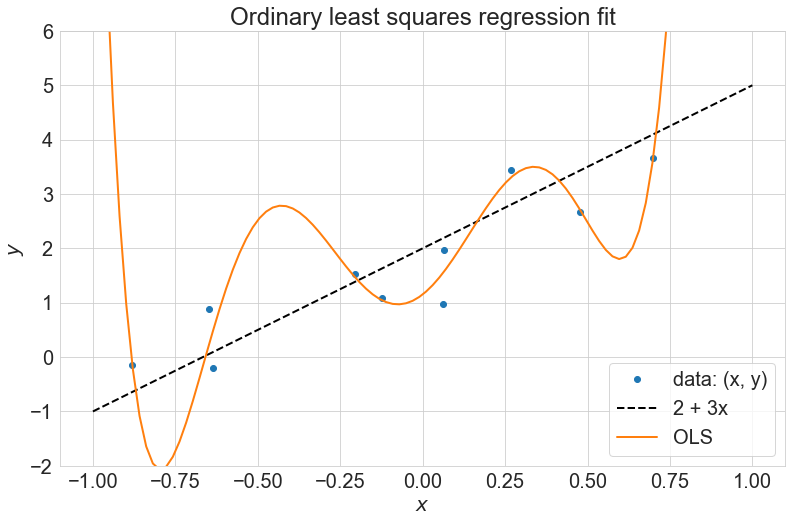

In [17]:
graph_support.hide_code_in_slideshow()

# Show OLS fitted line
plt.figure(figsize=(13, 8))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

In [18]:
print('Вектор коэффициентов: ', np.round(Alpha, 3))

Вектор коэффициентов:  [   1.152    4.779   29.398  -36.127 -134.751   67.44   154.827]


Итак, мы построили регрессионный полином 7-го порядка, но результат нас не устраивает.
В точках обучающей выборки функция регрессии $g(x, \alpha)$ хорошо приближает наши данные, но в промежутках функцию $g(x, \alpha)$ прилично &laquo;трясёт&raquo;.
Мы столкнулись с проблемой мультиколлинеарности.

В прошлый раз мы рассмотрели один из трёх запланированных методов решения проблемы &mdash; метод главных компонент. Нам осталось два: гребневая регрессия и метод LASSO.

---

## Гребневая регрессия

Одним из симптомов проблемы мультиколлинеарности является большой разброс значений $\alpha^*$.

Попробуем решить проблему &laquo;симптоматически&raquo;.
Добавим к функционалу $Q$ регуляризатор, штрафующий большие значения нормы вектора весов $\Vert \alpha \Vert$:

$$ Q_\delta(\alpha) = \Vert F\alpha - y \Vert^2 + \delta^2 \Vert \alpha \Vert^2, $$

где $\delta^2$ &mdash; неотрицательный параметр.

Штрафное слагаемое выполняет роль регуляризатора, благодаря которому среди среди всех возможных выбирается решение с минимальной нормой.



Приравнивая нулю производную $Q_\delta (\alpha)$ по параметру $\alpha$, находим:

$$ \alpha_\delta^\ast = (F^\top F + \delta^2 I_n)^{-1} F^\top y. $$

Таким образом, перед обращением матрицы к ней **добавляется &laquo;гребень&raquo; &mdash;** диагональная матрица $\delta^2 I_n$.

При этом все её собственные значения увеличиваются на $\delta^2$ , а собственные векторы не изменяются.
В результате матрица становится хорошо обусловленной, оставаясь в то же время &laquo;похожей&raquo; на исходную.

Выразим регуляризованное МНК-решение через сингулярное разложение:
$$ F^\top F + \delta^2 I = V\Sigma^\top U^\top \cdot U \Sigma V^\top + \delta^2 VIV^\top = V (\Sigma^\top \Sigma + \delta^2 I) V^\top, $$


$$ \alpha_\delta^* = (F^\top F + \delta^2 I_n)^{-1} F^\top y = V (\Sigma^\top \Sigma + \delta^2 I)^{-1} V^\top \cdot V \Sigma^\top U^\top y = \\
= V \left[ (\Sigma^\top \Sigma + \delta^2 I)^{-1} \Sigma^\top \right] U^\top y = \sum_{j=1}^n \frac{\sigma_j}{\sigma_j^2 + \delta^2} v_j (u_j^\top y). \label{eq:alpha-tau-res}\tag{2} $$

Теперь найдём регуляризованную МНК-аппроксимацию целевого вектора $y$:

$$ F\alpha_\delta^\ast = U \Sigma V^\top \alpha_\delta^* = U \mathrm{diag}\left( \frac{\sigma_j^2}{\sigma_j^2 + \delta^2} \right) U^\top y
= \sum_{j=1}^n \frac{\sigma_j^2}{\sigma_j^2 + \delta^2} u_j (u_j^\top y).  \label{eq:F-alpha-tau-res}\tag{3} $$

Как и прежде, МНК-аппроксимация представляется в виде разложения целевого вектора $y$ по базису собственных векторов матрицы $FF^\top$.
Только теперь норма проекций на собственные векторы уменьшается, умножаясь на $\frac{\sigma_j^2}{\sigma_j^2 + \delta^2} \in (0, 1)$.

Уменьшается и норма вектора коэффициентов:

$$ \Vert \alpha_\delta^{\ast} \Vert^2 = \Vert V(\Sigma^2 + \delta I_n)^{-1} \Sigma U^\top y \Vert^2
= \sum_{j=1}^n \frac{\sigma_j^2}{(\sigma_j^2 + \delta^2)^2} (u_j^\top y)^2 < \sum_{j=1}^n \frac{1}{\sigma_j} (u_j^\top y)^2
= \Vert \alpha^{\ast} \Vert^2. \label{eq:alpha-tau-es-norm}\tag{4} $$

### Выбор константы регуляризации ###

При $\delta^2 \to 0$ регуляризованное решение стремится к МНК-решению: $\alpha_\delta^\ast \to \alpha^\ast$.

При $\delta^2 \to \infty$ чрезмерная регуляризации приводит к вырожденному решению: $\alpha^\ast_\delta \to 0$.

Оба крайних случая нежелательны, поэтому оптимальным является некоторое промежуточное значение $\delta^2_\ast$.

Значение $\delta^2$ можно выбирать так, чтобы число обусловленности приняло заданное не слишком большое значение:

$$ \mu_\ast = \mu(F^\top F + \delta^2 I_n) = \frac{\sigma^2_\mathrm{max} + \delta^2}{\sigma^2_\mathrm{min} + \delta^2}, $$

откуда следует эвристика
$$ \delta^2_\ast \approx \sigma^2_\mathrm{max}/\mu_\ast. $$

In [19]:
# SVD
U, sgm, Vt = np.linalg.svd(F, full_matrices=False)

In [20]:
# Fit parameters with ridge regression
mu_s = 1e2   # desired condition number
delta2 = max(sgm)**2 / mu_s
print('sigma =', np.round(sgm, 3))
print('delta2 =', np.round(delta2, 3))
Alpha_r = sum([sgm[i]/(sgm[i]**2 + delta2) * Vt[i] * (U.T[i] @ y) for i in range(Nf)])
print('Alpha_r =', np.round(Alpha_r, 3))

# Function representing fitted line
ridge = lambda x: sum([Alpha_r[i]*x**i for i in range(Nf)])

sigma = [3.353 1.838 0.846 0.348 0.136 0.028 0.005]
delta2 = 0.112
Alpha_r = [1.681 2.187 0.468 0.339 0.05  0.125 0.03 ]


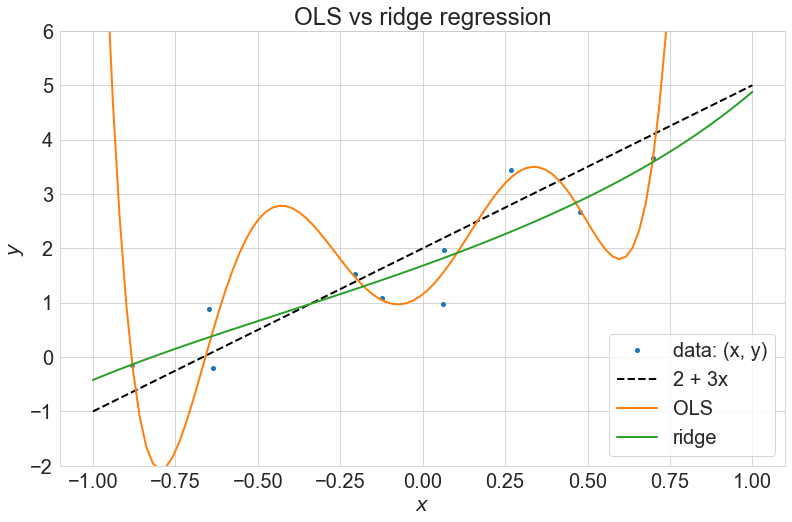

In [21]:
graph_support.hide_code_in_slideshow()

# Show OLS fitted line
plt.figure(figsize=(13, 8))
plt.title('OLS vs ridge regression')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, ridge(X), '-', label='ridge')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Лассо Тибширани

Введём ограничение-неравенство, запрещающее слишком большие абсолютные значения коэффициентов.

Для ограничения длины вектора коэффициентов $\alpha$ используется норма $L_1$:

$$
\left\{
\begin{aligned}
    & Q(\alpha) = \Vert F\alpha - y \Vert^2 \to \min_\alpha \\
    & \|\alpha\|_1 \le \chi
\end{aligned}
\right.,
\label{eq:lasso}\tag{5}
$$
где $\chi$ &mdash; параметр регуляризации.

При больших значениях $\chi$ ограничение становится строгим неравенством, и решение совпадает с МНК-решением. \
Чем меньше $\chi$, тем больше коэффициентов $\alpha_j$ **обнуляются**. \
Происходит отбор (селекция) признаков, поэтому параметр $\chi$ называют ещё **селективностью**.


In [22]:
def Q_obj(a):
    '''Q - objective function'''
    return np.linalg.norm((F @ a - y))**2

def constr(a):
    '''Constraint'''
    return LA.norm(a, ord=1)

def solve_lasso(Q_obj, constr, chi):
    '''solve LASSO optimization task'''
    nonlinear_constraint = NonlinearConstraint(constr, 0., chi)
    N_ms = 10   # multistart
    res = []
    for i in range(N_ms):
    # Alpha_0 = np.zeros(Nf)    # initial approximation
        Alpha_0 = 10*np.random.rand(Nf) - 5
        res.append(minimize(Q_obj, Alpha_0, method='SLSQP', constraints=nonlinear_constraint))
    argmin = np.argmin([item.fun for item in res])
    return res[argmin]

In [23]:
# solve LASSO optimization task
chi = 4    # the max constraint for the decision vector
res = solve_lasso(Q_obj, constr, chi)
Alpha_l = res.x
lasso = lambda x: sum([Alpha_l[i]*x**i for i in range(Nf)])

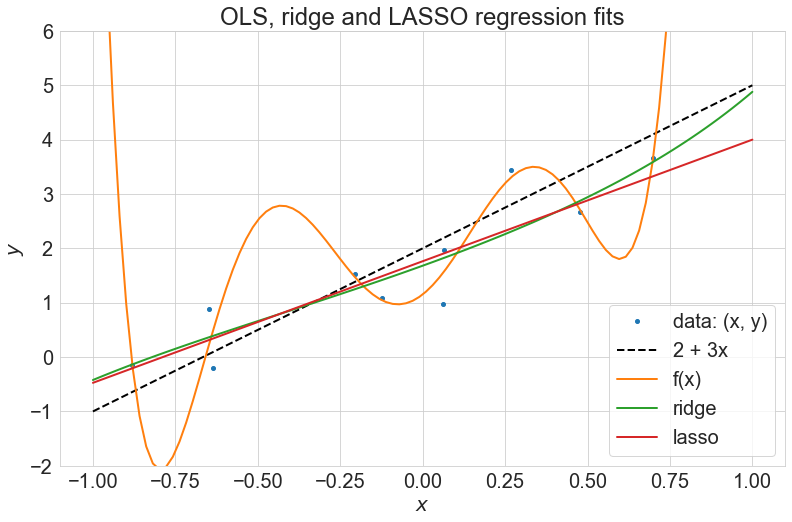

In [24]:
graph_support.hide_code_in_slideshow()

# Show OLS fitted line
plt.figure(figsize=(13, 8))
plt.title('OLS, ridge and LASSO regression fits')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='f(x)')
plt.plot(X, ridge(X), '-', label='ridge')
plt.plot(X, lasso(X), '-', label='lasso')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

In [25]:
print(f'OLS:   a = {np.round(Alpha, 3)}\nnorm(a) = {constr(Alpha)}, Q = {Q_obj(Alpha)}\n')
print(f'ridge: a = {np.round(Alpha_r, 3)}\nnorm(a) = {constr(Alpha_r)}, Q = {Q_obj(Alpha_r)}\n')
print(f'LASSO: a = {np.round(Alpha_l, 3)}\nnorm(a) = {constr(Alpha_l)}, Q = {Q_obj(Alpha_l)}\n')

OLS:   a = [   1.152    4.779   29.398  -36.127 -134.751   67.44   154.827]
norm(a) = 428.4740330707647, Q = 1.4726404272486602

ridge: a = [1.681 2.187 0.468 0.339 0.05  0.125 0.03 ]
norm(a) = 4.879337051881616, Q = 2.8531524369506758

LASSO: a = [ 1.763  2.237  0.    -0.    -0.    -0.    -0.   ]
norm(a) = 4.000000982817314, Q = 2.9828090972762267



---

## Сравнение лассо и гребневой регрессии

Оба метода успешно решают проблему мультиколлинеарности.

Гребневая регрессия использует все признаки, лассо производит отбор признаков.

Сравним гребневую регрессию и лассо. \
Ослабление регуляризации (рост параметров $\varepsilon = 1/\delta^2$ и $\chi$) ведёт к уменьшению ошибки на обучении и увеличению нормы вектора коэффициентов.

In [58]:
eps = 1e-1
Eps = np.arange(eps, 1e2*eps, 1e0*eps)
AA = np.empty((len(Eps), len(sgm)))
for i, eps in enumerate(Eps):
    AA[i] = sum([sgm[i]/(sgm[i]**2+1/eps) * Vt[i] * (U.T[i] @ y) for i in range(Nf)])

In [32]:
Chi = np.linspace(0., 10., 21)
BB = np.empty((len(Chi), len(sgm)))

for i, chi in enumerate(Chi):
    res = solve_lasso(Q_obj, constr, chi)
    BB[i] = res.x

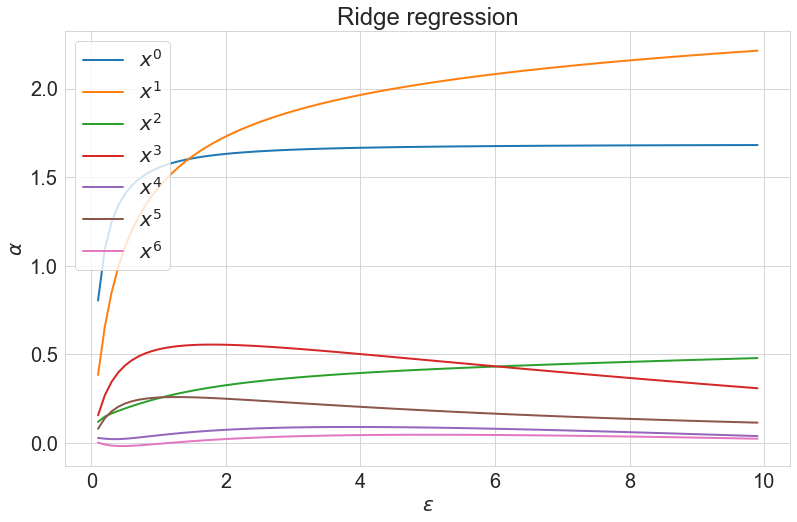

In [59]:
graph_support.hide_code_in_slideshow()

# plot
plt.figure(figsize=(13, 8))
plt.title('Ridge regression')

for i, aa in enumerate(AA.T):
    plt.plot(Eps, aa, '-', label=f'$x^{i}$')
plt.xlabel('$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.legend(loc=2)
plt.show()

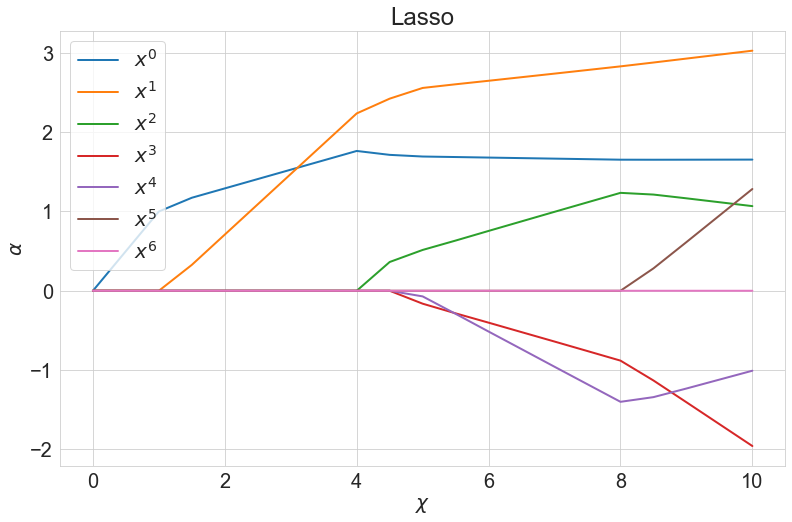

In [53]:
graph_support.hide_code_in_slideshow()

# plot
plt.figure(figsize=(13, 8))
plt.title('Lasso')

for i, bb in enumerate(BB.T):
    plt.plot(Chi, bb, '-', label=f'$x^{i}$')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\alpha$')
# plt.ylim((1, 6))
plt.legend(loc=2)
plt.show()

---

## Источники ##

1. *Лабинцев А.* [Scipy, оптимизация.](https://habr.com/ru/post/439288/)
1. *Воронцов К.В.* [Математические методы обучения по прецедентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). &mdash; 141 c.
1. *Strang G.* Linear algebra and learning from data. &mdash; Wellesley-Cambridge Press, 2019. &mdash; 432 p.

In [30]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(seaborn.__version__))
print('scipy: {}'.format(sp.__version__))

Python: 3.7.11
numpy: 1.21.2
matplotlib: 3.4.2
seaborn: 0.11.2
scipy: 1.7.1
